# Example 03. Process a LEAF time-series

This example generates analyzes a Plant Area Volume Density (PAVD) profile time-series acquired by a LEAF instrument.

## Load all the required modules

In [1]:
import os
import glob
import numpy as np
from datetime import timedelta
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import matplotlib

from pylidar_canopy import leaf_io, plant_profile, grid
from pylidar_canopy.rsmooth import rsmooth

## Some plotting functions

In [2]:
def plot_vertical_profiles(profiles, height, labels=['Hinge','Linear','Weighted'], title=None,
                          figsize=[6,6], ylim=(0,50), xlim=None, xlabel=r'PAVD ($m^2 m^{-3}$)'):
    """Example function to plot a vertical profile"""
    fig, ax = plt.subplots(figsize=figsize, squeeze=True)
    with plt.style.context('seaborn-talk'):
        for i,profile in enumerate(profiles):
            if labels is None:
                ax.plot(profile, height, linewidth=1.5)
            else:
                ax.plot(profile, height, label=labels[i], linewidth=1.5)
        ax.set(xlabel=xlabel, ylabel='Height (m)')
        ax.set(ylim=ylim, xlim=xlim, title=title)
        ax.set_facecolor('white')
        if labels is not None:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout() 
    plt.show()

def plot_leaf_grid(data, inset=None, label='Range (m)', clim=[0,30], figsize=(16,10), nbins=10,
                   cmap='bone', inset_cmap='Greens_r', nreturns=None, extend='max', nodata=-9999, 
                   extent=None, xlabel=None, ylabel=None, facecolor='white', title=False):
    """Example function to plot a LEAF grid"""
    if nreturns is None:
        nreturns = data.shape[0]
    fig, ax = plt.subplots(ncols=1, nrows=nreturns, squeeze=False, 
                           sharex=False, sharey=False, figsize=figsize)
    with plt.style.context('seaborn-notebook'):
        for i in range(nreturns):  
            ax[i,0].set_facecolor(facecolor)
            ax[i,0].set(adjustable='box', aspect='equal')
            ax[i,0].set(xlabel=xlabel, ylabel=ylabel)
            if title and nreturns > 1:
                ax[i,0].set_title(f'Return {i+1:d} (maximum {data.shape[0]:d})', fontsize=14)
            if extent is None:
                ax[i,0].get_xaxis().set_visible(False)
                ax[i,0].get_yaxis().set_visible(False)
            tmp = np.ma.masked_equal(data[i], nodata)
            p = ax[i,0].imshow(tmp, interpolation='none', clim=clim, 
                               cmap=matplotlib.cm.get_cmap(cmap,nbins),  
                               vmin=clim[0], vmax=clim[1], extent=extent)
            if inset is not None:
                tmp = np.ma.masked_equal(inset[i], nodata)
                pi = ax[i,0].imshow(tmp, interpolation='none', clim=clim, 
                                    cmap=matplotlib.cm.get_cmap(inset_cmap,nbins),  
                                    vmin=clim[0], vmax=clim[1], extent=extent)
            divider = make_axes_locatable(ax[i,0])
            cax = divider.append_axes('right', size='2%', pad=0.05)
            cbar = fig.colorbar(p, label=label, cax=cax, extend=extend)
            cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=nbins))
    fig.tight_layout()
    plt.show()
    
def plot_xyz(x, y, z, c, figsize=[8,8], elev=None, azim=None, cmap='viridis', xylim=(None,None)):
    """Example function to plot the LEAF point cloud""" 
    fig = plt.figure(figsize=figsize)
    with plt.style.context('seaborn-talk'):
        ax = fig.add_subplot(projection='3d')
        ax.set_box_aspect([np.ptp(x), np.ptp(y), np.ptp(z)])
        ax.scatter(x, y, z, c=c, s=3, cmap=cmap)
        ax.set(xlabel='X (m)', ylabel='Y (m)', zlabel='Z (m)', xlim=xylim, ylim=xylim)
        ax.view_init(elev, azim)
    fig.tight_layout()
    plt.show()    

def plot_timseries_2d(data, clim=[0,0.2], title=None, nbins='auto', cmap='gist_earth', 
    label=r'PAVD ($m^{2} m^{-3}$)', facecolor='0.5', extend='max', extent=None, 
    figsize=(20,10), xticks=None):
    """Example function to plot a 2D histogram of the LEAF PAVD time-series""" 
    fig, ax = plt.subplots(ncols=1, nrows=1, squeeze=True, figsize=figsize)
    with plt.style.context('seaborn-talk'):
        ax.set_facecolor(facecolor)
        ax.set(adjustable='datalim', xlabel='Date', ylabel='Height (m)')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%-d-%b-%y')
        ax.xaxis.set_major_formatter(date_format)
        if xticks is not None:
            ax.set_xticks(xticks)
        if title is not None:
            ax.set_title(title)
        p = ax.imshow(data, interpolation='none', clim=clim, cmap=cmap, alpha=1.0, 
                      vmin=clim[0], vmax=clim[1], extent=extent, aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='2%', pad=0.05)
        cbar = fig.colorbar(p, label=label, cax=cax, extend=extend)
        cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=nbins))
        
    fig.tight_layout()
    plt.show()

    
def plot_timseries_1d(dates, values, quality, fitted=None, xlim=[None,None], ylim=[0,None], 
    title=None, ylabel=r'PAI ($m^{2} m^{-2}$)', linestyle=None, figsize=(20,10)):
    """Example function to plot a 2D histogram of the LEAF PAVD time-series""" 
    fig, ax = plt.subplots(ncols=1, nrows=1, squeeze=True, figsize=figsize)
    with plt.style.context('seaborn-talk'):
        ax.scatter(dates[quality], values[quality], linestyle=linestyle, color='DarkGreen', label='True')
        ax.scatter(dates[~quality], values[~quality], linestyle=linestyle, color='Brown', label='False')
        if fitted is not None:
            ax.plot(dates, fitted, linestyle=linestyle, color='Black')
        date_format = mdates.DateFormatter('%-d-%b-%y')
        ax.xaxis.set_major_formatter(date_format)
        ax.set(xlabel='Date', ylabel=ylabel, xlim=xlim, ylim=ylim)
    fig.autofmt_xdate()
    plt.legend(title='Quality')
    plt.tight_layout()
    plt.show()

## Identify all of the input files

Create a list of all files available to generate a time-series.

In [3]:
# SERC
sensor = 361
os.chdir(f'/gpfs/data1/vclgp/data/leaf/serc/21Dec22/{sensor:d}')
hemi_csv_list = glob.glob('data/ESS?????_*_hemi_*.csv')
hinge_csv_list = glob.glob('data/ESS?????_*_hinge_*.csv')
ground_csv_list = glob.glob('data/ESS?????_*_ground_*.csv')
power_csv_list = glob.glob('pwr/ESS?????_pwr_*.csv')

hemi_file = 'data/ESS00361_0486_hemi_20221220-080028Z_0800_0400.csv'
hinge_file = 'data/ESS00361_0484_hinge_20221220-060028Z_0005_5410.csv'

# Wytham
#sensor = 301
#os.chdir(f'/gpfs/data1/vclgp/data/leaf/wytham/{sensor:d}')
#hemi_csv_list = glob.glob('ESS?????_*_hemi_*.csv')
#hinge_csv_list = glob.glob('ESS?????_*_hinge_*.csv')

In [4]:
f = leaf_io.LeafScanFile(hemi_csv_list[1], sensor_height=1.5)
f.data.head()

,sample_count,scan_encoder,rotary_encoder,range1,intensity1,range2,sample_time,target_count,datetime,zenith,azimuth,x1,y1,z1,h1,x2,y2,z2,h2
0,27,1400.0,0,0.71,100,0.66,37.29,2,2022-10-25 02:00:28.037290,2.246974,2.953128,0.103751,-0.543973,-0.444330,1.055670,0.096445,-0.505665,-0.413039,1.086961
1,28,1450.0,0,0.94,100,0.86,37.05,2,2022-10-25 02:00:28.074340,2.215558,2.953128,0.140755,-0.737985,-0.564948,0.935052,0.128776,-0.675178,-0.516867,0.983133
2,29,1500.0,0,1.31,100,1.18,36.09,2,2022-10-25 02:00:28.110430,2.184142,2.953128,0.200695,-1.052254,-0.754045,0.745955,0.180779,-0.947832,-0.679216,0.820784
3,30,1550.0,0,1.52,100,1.86,35.48,2,2022-10-25 02:00:28.145910,2.152726,2.953128,0.237901,-1.247329,-0.835448,0.664552,0.291116,-1.526336,-1.022325,0.477675
4,31,1600.0,0,2.27,100,2.22,36.80,2,2022-10-25 02:00:28.182710,2.121310,2.953128,0.362454,-1.900364,-1.187494,0.312506,0.354470,-1.858506,-1.161338,0.338662


## Visualize the 3D point cloud

Let's check the hinge angle scan is where we think it is

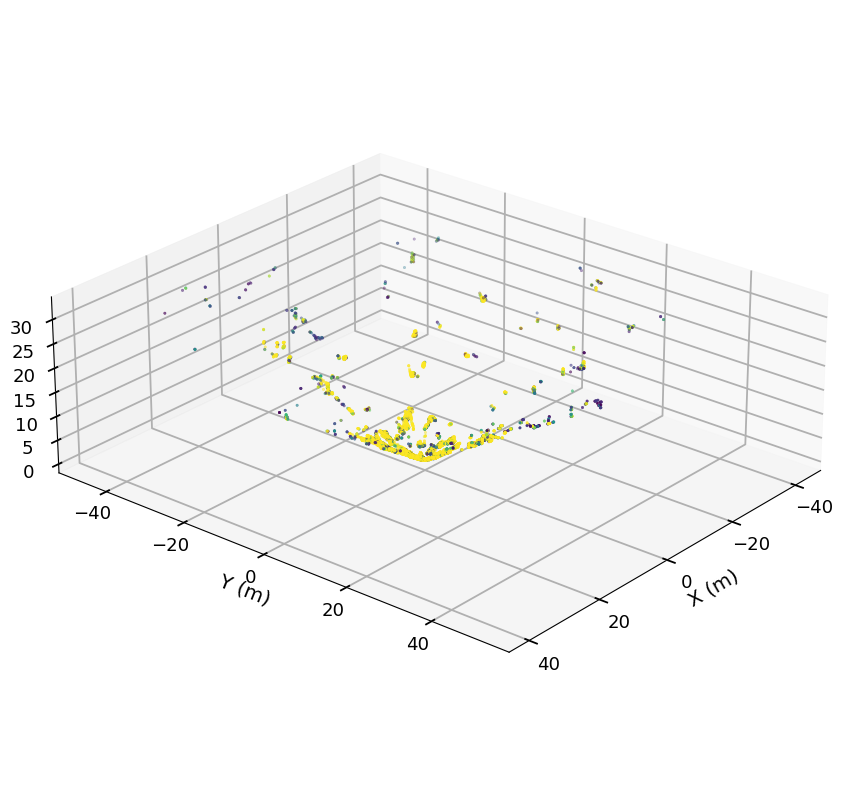

In [5]:
df = leaf_io.LeafScanFile(hinge_file, sensor_height=1.5).data
valid = ~(np.isnan(df.x1) | np.isnan(df.y1) | np.isnan(df.z1))
plot_xyz(df.x1[valid], df.y1[valid], df.z1[valid], df.intensity1[valid], 
         figsize=[8,8], elev=25, azim=40, cmap='viridis')

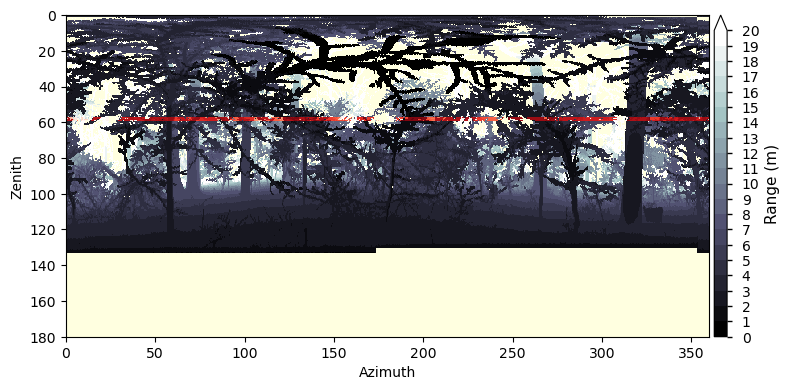

In [6]:
leaf_hemi_grid = grid.grid_leaf_spherical(hemi_file, 0.45, attribute='range1',
    method='MIN', sensor_height=1.5)

leaf_hinge_grid = grid.grid_leaf_spherical(hinge_file, 0.45, attribute='range1',
    method='MIN', sensor_height=1.5)

plot_leaf_grid(leaf_hemi_grid, label='Range (m)', clim=[0,20], figsize=(8,6), 
               nbins=20, cmap='bone', extent=[0,360,180,0], inset=leaf_hinge_grid,
               xlabel='Azimuth', ylabel='Zenith', facecolor='lightyellow', inset_cmap='Reds_r')

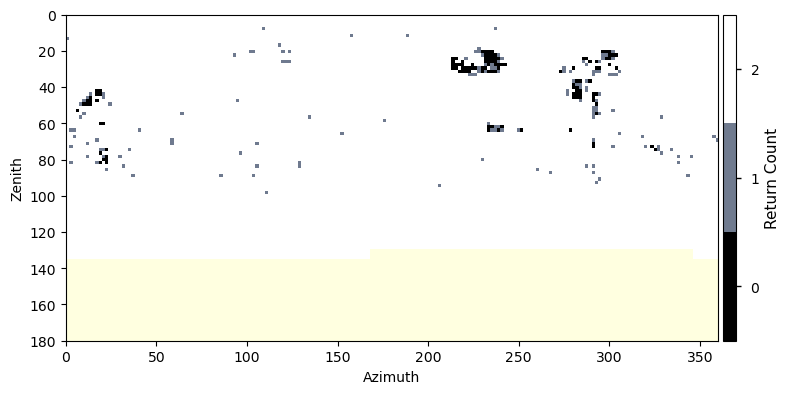

In [7]:
leaf_spherical_grid = grid.grid_leaf_spherical(hemi_csv_list[0], 1.8, attribute='target_count',
    method='MIN', sensor_height=1.5)

plot_leaf_grid(leaf_spherical_grid, label='Return Count', clim=[-0.5,2.5], figsize=(8,6), 
               nbins=3, cmap='bone', extent=[0,360,180,0], xlabel='Azimuth', 
               ylabel='Zenith', facecolor='lightyellow', extend='neither')

## Generate $P_{gap}$ profiles for a single hemi scan

Plot the $P_{gap}$ profiles for an example scan. There are different methods used for $P_{gap}$ estimation: WEIGHTED (weighting of returns by 1 / target_count); FIRST (first returns only), ALL (all returns), FIRSTLAST (each return has a weight of 0.5).

I'm currently using the FIRSTLAST method for LEAF data, since first and last returns from the same target will often be from extended targets and the interception will have a weight of 1 (each return from the same pulse will typically fall within the same height bin), and returns distributed along the beam path will have a lower weighting that is more appropriate for partial interceptions.

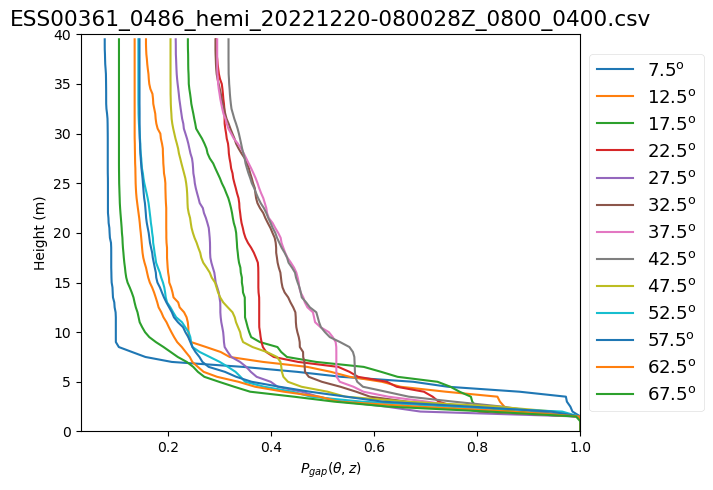

In [8]:
vpp = plant_profile.Jupp2009(hres=0.5, zres=5, ares=90, min_z=5, max_z=70, min_h=0, max_h=40)
valid = vpp.add_leaf_scan_position(hemi_file, method='FIRSTLAST', 
                                   min_zenith=5, max_zenith=70, sensor_height=1.5)
if valid:
    vpp.get_pgap_theta_z()
    title = os.path.basename(hemi_file)
    pgap_labels = [fr'{b:.1f}$\rm ^o$' for b in vpp.zenith_bin]
    plot_vertical_profiles(vpp.pgap_theta_z, vpp.height_bin, xlabel=r'$P_{gap}(\theta,z)$',
                           labels=pgap_labels, ylim=[0,40], xlim=[None,1], figsize=[7,5], title=title)

## Compare the hinge and hemi scans for the same date

The hinge scans are designed for PAI profiles and the hemi scans for visualization of terrain and understorey structure. 
But can they produce the same vertical profiles?

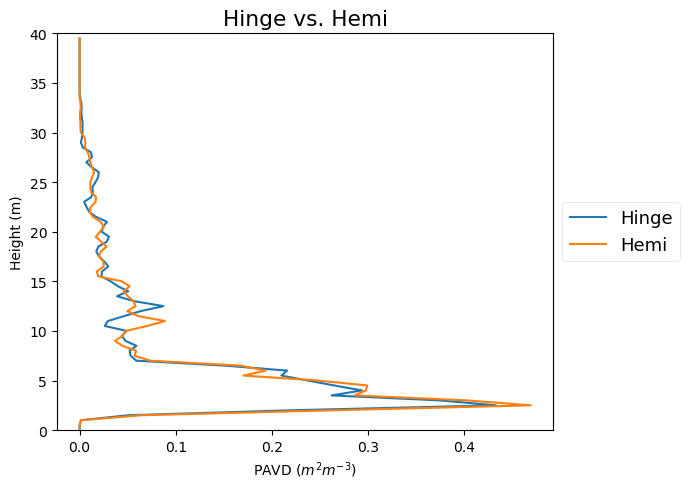

In [9]:
hemi_vpp = plant_profile.Jupp2009(hres=0.5, zres=5, ares=90, min_z=55, max_z=60, min_h=0, max_h=40)
hemi_valid = hemi_vpp.add_leaf_scan_position(hemi_file, method='FIRSTLAST', 
                                   min_zenith=55, max_zenith=60, sensor_height=1.5)
hemi_vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)
hemi_pai = hemi_vpp.calcHingePlantProfiles()
hemi_pavd = hemi_vpp.get_pavd(hemi_pai)

hinge_vpp = plant_profile.Jupp2009(hres=0.5, zres=5, ares=90, min_z=55, max_z=60, min_h=0, max_h=40)
hinge_valid = hinge_vpp.add_leaf_scan_position(hinge_file, method='FIRSTLAST', 
                                   min_zenith=55, max_zenith=60, sensor_height=1.5)
hinge_vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)
hinge_pai = hinge_vpp.calcHingePlantProfiles()
hinge_pavd = hinge_vpp.get_pavd(hinge_pai)

plot_vertical_profiles([hinge_pavd,hemi_pavd], vpp.height_bin, 
   labels=['Hinge','Hemi'], ylim=[0,40], figsize=[7,5], title='Hinge vs. Hemi')

## Analyze the PAI time-series

Analysis of the daily time-series is needed for filtering of observations affected by wind, rain or other pertubations. Here we use robust smoothing of regular time-series data to identify outliers, but these should be checked against auxillary data. Temperature, humidity, and power data recorded by the LEAF instrument did not appear to be related to these outliers, at least for this example. Given this example is a deciduous forest, we also fit a sigmoid function to time-series to quantify the change in PAI during senescence and leaf drop.

In [10]:
hres = 0.5
max_h = 40
nbins = int(max_h / hres)

leaf_hinge_files = sorted(hinge_csv_list)
nobs = len(leaf_hinge_files)

In [11]:
leaf_hinge_dates = np.empty(nobs, dtype='O')
leaf_hinge_pai = np.full(nobs, np.nan, dtype=float)
leaf_hinge_pavd = np.full((nbins,nobs), np.nan, dtype=float)

for i,leaf_file in enumerate(leaf_hinge_files):
    vpp = plant_profile.Jupp2009(hres=hres, zres=5, ares=90, min_h=0, max_h=max_h)
    valid = vpp.add_leaf_scan_position(leaf_file, method='FIRSTLAST', 
                                       min_zenith=55, max_zenith=60, sensor_height=1.5)
    if valid:
        vpp.get_pgap_theta_z(min_azimuth=0, max_azimuth=360)
        pai = vpp.calcHingePlantProfiles()
        leaf_hinge_pavd[:,i] = vpp.get_pavd(pai)
        leaf_hinge_pai[i] = pai[-1]
    
    leaf_hinge_dates[i] = vpp.datetime


In [12]:
# Identify outliers in the time-series
leaf_hinge_pai_smooth,weights = rsmooth(leaf_hinge_pai)
bad_data = (weights < 0.05) & (leaf_hinge_pai < leaf_hinge_pai_smooth)

# Define a sigmoid function
def sigmoid(x, L , x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return y

# Fit the sigmoid function
real_dates = np.array([(d - leaf_hinge_dates[0]).total_seconds() for d in leaf_hinge_dates])
params, params_covariance = curve_fit(sigmoid, real_dates[~bad_data], leaf_hinge_pai[~bad_data], 
                                      p0=[-2.4,1.793e+06,4.844e-06,4.450e+00])

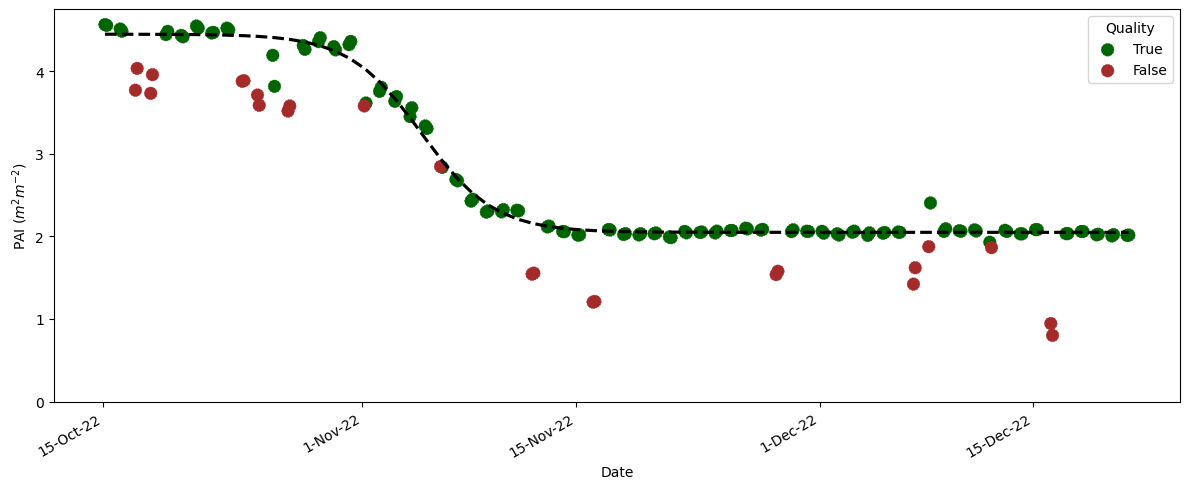

In [13]:
leaf_hinge_pai_sigmoid = sigmoid(real_dates, params[0], params[1], params[2], params[3])

plot_timseries_1d(leaf_hinge_dates, leaf_hinge_pai, ~bad_data, fitted=leaf_hinge_pai_sigmoid,
                  xlim=[None,None], ylim=[0,None], title=None, linestyle='dashed',
                  ylabel=r'PAI ($m^{2} m^{-2}$)', figsize=(12,5))

## Grid the daily PAVD time-series

Aggregate the data on a regular daily grid. Note that two LEAF instruments at this site had their DC cards switched, so the source data needs to be corrected.

In [14]:
res = 1
ndays = (leaf_hinge_dates[-1] - leaf_hinge_dates[0]).days
ncols = ndays // res + 1

with grid.LidarGrid(ncols, nbins, 0, nbins, resolution=1, init_cntgrid=True) as grd:
    
    for i in range(leaf_hinge_dates.shape[0]):
        if not bad_data[i]:
            day = (leaf_hinge_dates[i] - leaf_hinge_dates[0]).days
            col = day // res
            grd.add_column(leaf_hinge_pavd[:,i], col, method='MEAN')
        
    grd.finalize_grid(method='MEAN')
    pavd_grid = grd.get_grid()

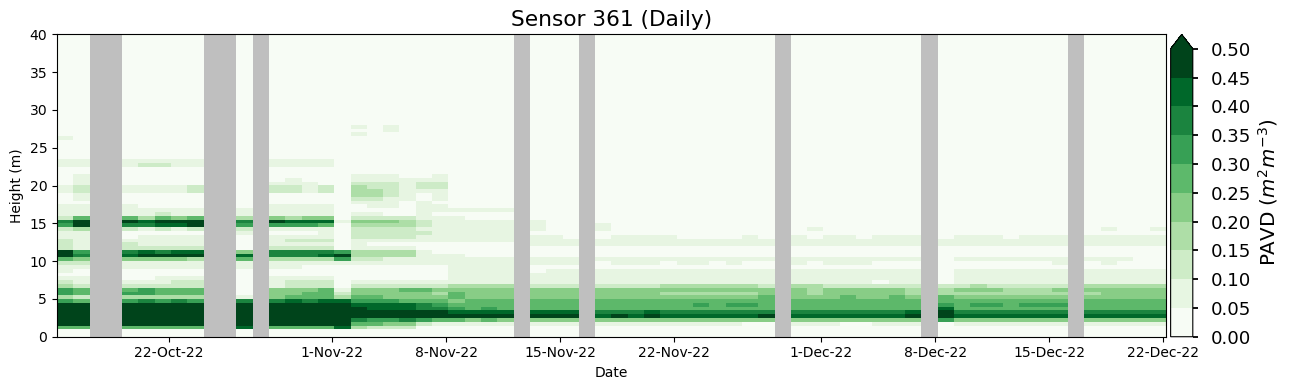

In [15]:
max_date = leaf_hinge_dates[0] + timedelta(days=res * ncols)
extent = [mdates.date2num(leaf_hinge_dates[0]),mdates.date2num(max_date),0,max_h] 

pavd_grid = np.ma.masked_equal(pavd_grid, -9999)

plot_timseries_2d(pavd_grid[0,::-1,:], clim=[0,0.5], title=f'Sensor {sensor:d} (Daily)', nbins=10, 
                  cmap=matplotlib.cm.get_cmap('Greens',10), label=r'PAVD ($m^{2} m^{-3}$)', 
                  facecolor='0.75', extend='max', extent=extent, figsize=(13,4))

## Grid the weekly PAVD time-series

Aggregation may be preferred to smoothing for gap filling and reducing noise

In [16]:
res = 7
ndays = (leaf_hinge_dates[-1] - leaf_hinge_dates[0]).days
ncols = ndays // res + 1

with grid.LidarGrid(ncols, nbins, 0, nbins, resolution=1, init_cntgrid=True) as grd:
    
    for i in range(leaf_hinge_dates.shape[0]):
        if not bad_data[i]:
            day = (leaf_hinge_dates[i] - leaf_hinge_dates[0]).days
            col = day // res
            grd.add_column(leaf_hinge_pavd[:,i], col, method='MEAN')
        
    grd.finalize_grid(method='MEAN')
    pavd_grid = grd.get_grid()

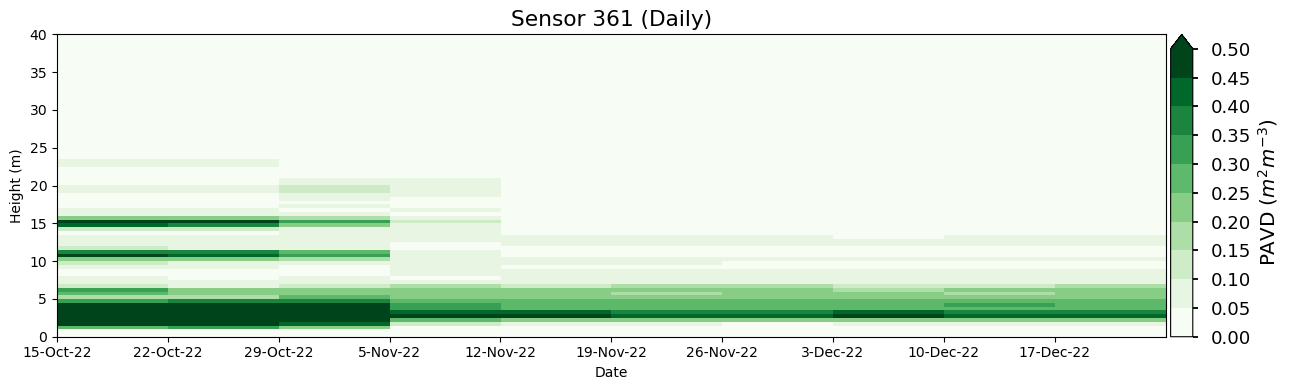

In [17]:
max_date = leaf_hinge_dates[0] + timedelta(days=res * ncols)
extent = [mdates.date2num(leaf_hinge_dates[0]),mdates.date2num(max_date),0,max_h] 
xticks = [mdates.date2num(leaf_hinge_dates[0] + timedelta(days=res*x)) for x in range(ncols)]

pavd_grid = np.ma.masked_equal(pavd_grid, -9999)

plot_timseries_2d(pavd_grid[0,::-1,:], clim=[0,0.5], title=f'Sensor {sensor:d} (Daily)', nbins=10, 
                  cmap=matplotlib.cm.get_cmap('Greens',10), label=r'PAVD ($m^{2} m^{-3}$)', 
                  facecolor='0.75', extend='max', extent=extent, figsize=(13,4), xticks=xticks)